# Tolman-Oppenheimer-Volkoff (TOV) equations
---

The TOV equations describe spherically symmetric stars in equilibrium.

Consider a spherically symmetry time-independent metric,
\begin{align*}
    \text{d} s^{2} \ = \ - e^{2\Phi} \text{d}t^{2} \ + \ \left(1 - \frac{2m(r)}{r} \right)^{-1} \text{d}r^{2} \ + \ r^{2} \text{d}\Omega^{2} .
\end{align*}
Note that, $m(r)$, here is not a constant but a function of $r$, providing us with a convenient way to parametrize the metric.

Consider the energy-momntum tensor of a perfect fluid,
\begin{align*}
    T_{\mu\nu} \ = \ \rho h u_{\mu} u_{\nu} \ + \ p g_{\mu\nu} . 
\end{align*}
in which $h = 1 + p / \rho$.

The Einstein equations, $G_{\mu\nu} = 8\pi T_{\mu\nu}$, for this system yield,
\begin{align*}
    \frac{\text{d} m}{\text{d} r}    \ &= \ 4\pi r^{2} \rho \\
    \frac{\text{d} P}{\text{d} r}    \ &= -\frac{\left(\rho + P\right)\left(m + 4\pi P r^{3}\right)}{r\left(r - 2m\right)} \\ 
    \frac{\text{d} \Phi}{\text{d} r} \ &= -\frac{\text{d}P}{\text{d}r} \left(\rho + P\right)^{-1}
\end{align*}
These are known as the TOV equations.

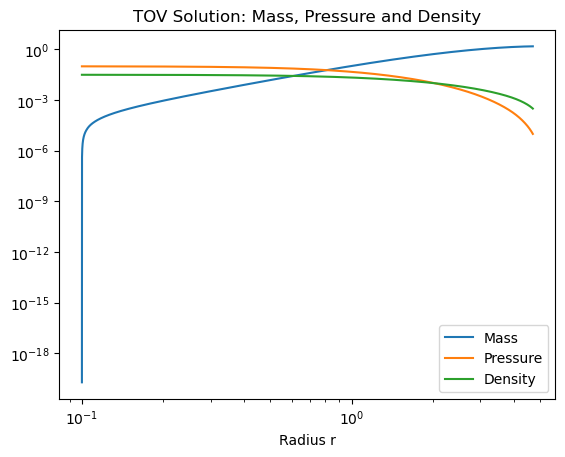

In [16]:
%reset -f 
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define model parameters
r_o   = 1.0e+3          # outer radius (maximum radius)
r_c   = 1.0e-1          # central radius (minimum radius)
dr    = 1.0e-5          # radius increment
P_c   = 1.0e-1          # central pressure (maximal pressure)
P_min = 1.0e-5

# Define polytropic constants (using c = G = 1 units for simplicity)
K     = 100    # Polytropic constant
Gamma = 2      # Polytropic exponent

# Polytropic Equation of State (EOS)
def pressure(rho):
    return K * rho**Gamma

def density(P):
    return (P / K)**(1 / Gamma)

# TOV Equations
def tov_integrate(r, y):
    P, m = y
    rho = density(P)
    dPdr = - (rho + P) * (m + 4 * np.pi * r**3 * P) / (r * (r - 2 * m))
    dmdr = 4 * np.pi * r**2 * rho
    return [dPdr, dmdr]

# Event equation
def stop_at_surface(r, y):
    P, m = y
    return P - P_min  # Stop when P is close to zero

stop_at_surface.terminal = True
stop_at_surface.direction = -1

# Solve the TOV equations
def solve_tov(P_c, r_c, r_o, dr):
    rho_c = density(P_c) 
    sol = solve_ivp(
        fun           = tov_integrate, 
        t_span        = [r_c, r_o], 
        y0            = [P_c, 0], 
        method        ='LSODA', 
        dense_output  = True,
        t_eval        = np.arange(r_c, r_o, dr),
        events        = stop_at_surface)
    
    r_values = sol.t
    P_values, m_values = sol.y
    sol_TOV = sol.sol
    
    return r_values, P_values, m_values, sol_TOV

# Central density
r, P, m, sol_TOV = solve_tov(P_c, r_c, r_o, dr)
rho = density(P)

# Plot the results
plt.figure
plt.plot(r, m, label='Mass')
plt.xlabel('Radius r')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.plot(r, P, label='Pressure')
plt.xlabel('Radius r')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.plot(r, rho, label='Density')
plt.xlabel('Radius r')
plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.title('TOV Solution: Mass, Pressure and Density')
plt.show()


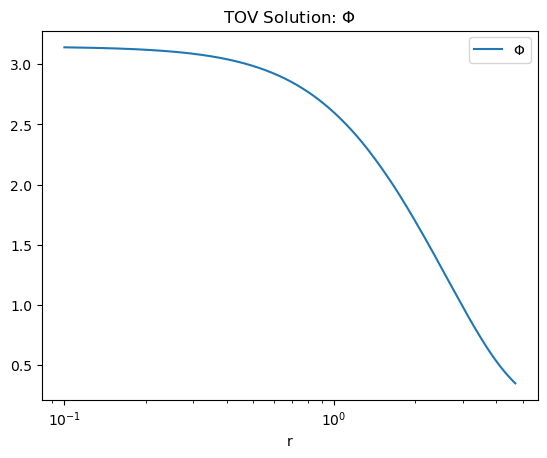

In [17]:
# Define the right-hand side of Phi equation
def solve_phi(r, y):

    # Interpolate m(r) and P(r) using the dense output function
    P, m = sol_TOV(r)  # sol_TOV is an interpolating function

    # Compute the right-hand side
    dPhi_dr = - (m + 4 * np.pi * P * r**3) / (r * (r - 2 * m))

    return [dPhi_dr]

# Solve the initial value problem for the Phi equation
sol_phi = solve_ivp(
    fun               = solve_phi,
    t_span            = np.array([r_c, r_o]),  
    y0                = np.array([-10]),
    method            = 'BDF',
    dense_output      = True,
    t_eval            = r 
)
    
# Extract the solution
r_phi = sol_phi.t
Phi   = sol_phi.y[0]

# Phi is only determined up to a constant and should satisfy the boundary condition: 
# e^(2 Phi) = 1 - 2M/r at the boundary where P(r) = 0
boundary_value = 1 - 2*m[-1]/r[-1]
Phi = Phi - Phi[-1] + boundary_value

# Compute the lapse function α = e^Φ
alpha = np.exp(Phi)

# Plot the solution
plt.figure
plt.plot(r_phi, Phi, label=r'$\Phi$')
plt.xscale('log')
plt.xlabel('r')
plt.legend();
plt.title(r'TOV Solution: $\Phi$');

## Manifestly conformally flat coordinates
---

The coordinates used above do not make the metric manifestly conformally flat.

Given a spatial metric of the form,
\begin{align*}
    \text{d} s^{2} \ = \ a^{2}(r) \text{d}r^{2} + r^{2} \text{d}\Omega^{2}
\end{align*}
it can be made manifestly conformally flat, by making the change of variables $R(r)$.
Defining the function, $A \equiv \partial_{R} r$, such that, $\text{d}r = A(r) \text{d}R$, and thus also, $A^{-1}=\partial_{r} R$, we find that,
\begin{align*}
    \text{d} s^{2} \ &= \ A^{2} a^{2} \left( \text{d}R^{2} + \frac{r^{2}}{A^{2} a^{2}} \, \text{d}\Omega^{2} \right) \\
                   \ &= \psi^{4} \left( \text{d}R^{2} + R^{2} \text{d}\Omega^{2} \right)
\end{align*}
To make the second equality hold, we require,
\begin{align*}
\psi^{-2}                          \ &= \ \frac{1}{a} \frac{\text{d} R}{\text{d} r} \\
\frac{\text{d} \log R}{\text{d} r} \ &= \ \frac{a(r)}{r}
\end{align*}
Hence, in the particular case above, where $a = \left(1 - 2m(r)/r \right)^{-1/2}$, we have,
\begin{align*}
    \frac{\text{d} \log R}{\text{d} r} \ &= \ \frac{1}{\sqrt{r \left(r - 2 m(r)\right)}}
\end{align*}
and the conformal factor can be obtained as,
\begin{align*}
    \psi \ &= \ \sqrt{\frac{r}{R}}
\end{align*}
Furthermore, note that we have,
\begin{align}
    \alpha \ = \ e^{\Phi} 
\end{align}
in which
\begin{align*}
    \frac{\text{d} \Phi}{\text{d} r} \ &= \frac{m + 4\pi P r^{3}}{r\left(r - 2m\right)}
\end{align*}


/tmp/ipykernel_21715/764134595.py:5: RuntimeWarning: invalid value encountered in sqrt
  dlogR_dr = 1 / np.sqrt(r * (r - 2 * m))


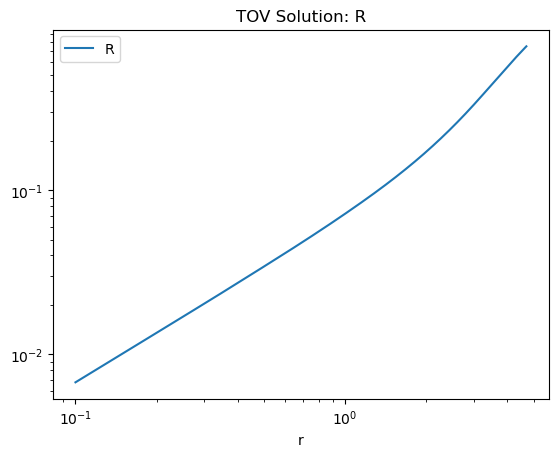

In [18]:
# Define the right-hand side of log R equation
def rhs(r, y):
    P, m = sol_TOV(r)
    # Compute the right-hand side
    dlogR_dr = 1 / np.sqrt(r * (r - 2 * m))
    # Return the right-hand side
    return [dlogR_dr]

# Solve the initial value problem for the log R equation
sol = solve_ivp(
    fun          = rhs,
    t_span       = np.array([r_c, r_o], dtype=np.float64),
    y0           = np.array([-5],      dtype=np.float64),
    method       = 'RK45',
    dense_output = True,
    t_eval       = r
)

# Extract the solution
r        = sol.t
R        = np.exp(sol.y[0])
sol_logR = sol.sol

# Compute the conformal factor \psi
psi = np.sqrt(r/R)

# Plot the solution
plt.plot(r, R, label='R')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('r')
plt.legend();
plt.title('TOV Solution: R');

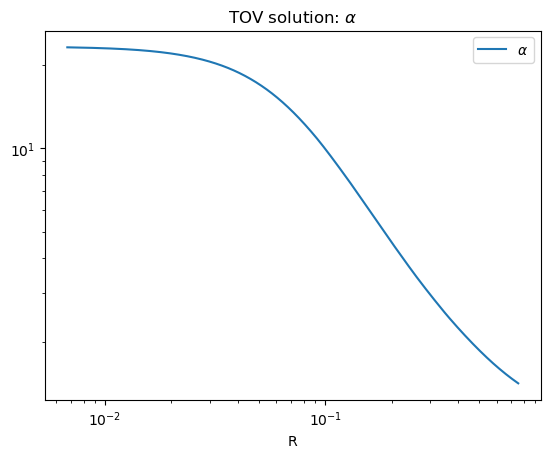

In [19]:
plt.plot(R, alpha, label=r'$\alpha$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('R')
plt.legend();
plt.title(r'TOV solution: $\alpha$');

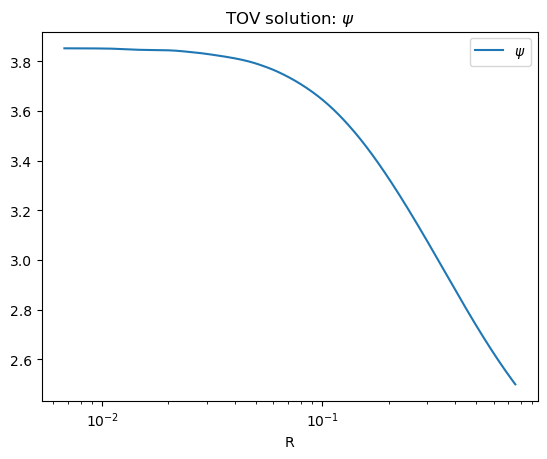

In [20]:
plt.plot(R, psi,   label=r'$\psi$')
plt.xscale('log')
# plt.yscale('log')
plt.xlabel('R')
plt.legend();
plt.title(r'TOV solution: $\psi$');

In [21]:
# Store the results
np.save(
    file = f'data/tov_{round(np.log10(r_o)):+}{round(np.log10(r_c)):+}{round(np.log10(P_c)):+}.npy',
    arr  = np.stack((r, m, P, rho, R, alpha, psi))
)